Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|
|imblearn|0.5.0|
|xgboost|0.80|

In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy 
import mlxtend
import statsmodels
import imblearn
import xgboost as xgb
import sys

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, imblearn, xgb]:
    print(i.__name__,  i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
imblearn 0.5.0
xgboost 0.80


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 대문항 세트2

최근 전세계적 에너지 부족 문제로 인하여 자가발전 건물에 대한 수요가 증가하고 있다. 

이러한 건물들은 외부로부터 전기를 공급받을 뿐 아니라, 

건물에 태양열 발전판 또는 풍력 발전기를 설치함으로써 자체적으로 에너지를 생산하여 건물 사용자들에게 제공한다.

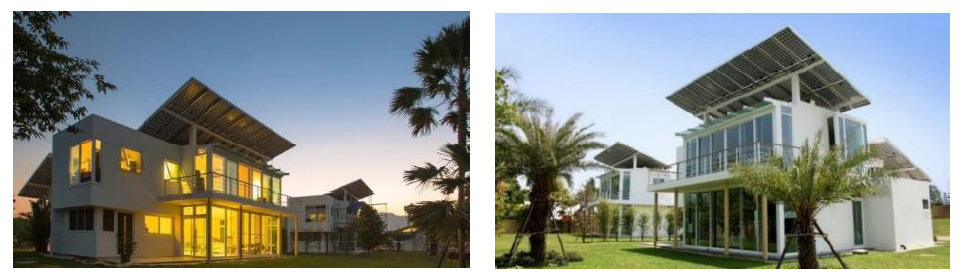

본 문제에서는 건물의 태양열 에너지 생산량을 분석하기 위해 총 두 종류의 데이터셋을 활용한다. 

첫 번째는 각 건물이 위치한 지역의 기상청으로부터 수집한 기후 정보 데이터이고, 

두 번째는 각 건물의 구조 및 시간대별로 측정한 에너지 소비량 등 건물 정보 데이터이다. 

이를 분석하여 어떤 기후 특성을 가진 지역에 자가발전 건물을 증설하는 것이 효율적인지 파악하고, 

건물 정보로부터 태양열 에너지 생산량 예측모델을 만들고자 한다.

**기후 정보 데이터** 먼저 기상청으로부터 수집한 기후 데이터는 다음의 파일로 구성되어 있다: 지역 및 시간대별 날씨 정보를 포함하고 있는 ‘prof2103_2_weather.csv’

**prof2103_2_weather.csv** (구분자: Comma(‘,’), 113,880 Rows, 8 Columns)

|컬럼명|설명|타입|예시|
|------|----|----|----|
|datetime|일시|String|2019-01-01 00:00:00|
|region_id|지역 번호|Double|0|
|temperature|기온|Double|1.9|
|cloud|구름 양|Double|8|
|dew_point|이슬점|Double|-12.2|
|rain_hourly|강우 시간|Double|0|
|air_pressure|기압|Double|1023.3|
|wind_direction|풍향|Double|250|

**prof2103_2_data.csv** (구분자: Comma(‘,’), 300,404 Rows, 3 Columns)

|칼럼 이름|설명|타입|예시|
|---------|----|----|----|
|datetime|일시|String|2019-01-01 00:00:00|
|user_id|건물 번호|Double|480|
|generate|(태양열) 에너지 생산량|Double|15.11|

**prof2103_2_building_metadata.csv** (구분자: Comma(‘,’), 1,449 Rows, 6 Columns)

|칼럼 이름|설명|타입|예시|
|---------|----|----|----|
|region_id|지역 번호|Double|6|
|user_id|건물 번호|Double|351|
|usage|사용용도|Double|4|
|area|건물면적|Double|58908|
|construct_year|준공연도|Double|1924|
|num_floors|층 수|Double|5|

**공통 전처리** 

**(prof2103_2_weather.csv사용)** 

'prof2103_2_weather.csv'에는 계측상의 한계로 관측되지 않은 데이터들이 존재한다. 

이를 선형 보간법(linear interpolation)으로 대체하여 ‘weather_dataset’ 테이블을 생성한다. 

이를 위해 아래의 단계를 순서대로 수행하시오.

**Step B-1**

전체 데이터셋을 지역 번호(region_id), 일시(datetime) 순서로 오름차순 정렬한 후, 

6개의 날씨정보 컬럼들(temperature ~ wind_direction)에 포함된 결측치(null) 대체를 위해 선형 보간법을 수행한다. 

이 때, 값 대체는 각 지역 번호(region_id)별로 수행한다.

 - 선형 보간법: 양 끝 점의 값이 주어졌을 때, 그 사이에 위치한 값을 추정하기 위하여 직선 거리에 따라 선형적으로 계산하는 방법.
 - prof2103_2_weather.csv에는 지역 번호(region_id)별 2019년의 모든 날짜와 시간대가 누락없이 포함되어 있다. (13 * 365 * 24 = 113,880)

구체적인 수행 절차는 다음과 같다. 

먼저 결측치가 존재하는 시점 t에 대해, t_0,x_0,t_1,x_1을 아래와 같이 정의하며, 

Case1~4 중 해당하는 경우에 따라 결측치를 대체한다.

> t_0 : t 시점 이전에 결측치가 아닌 값이 존재하는, 가장 가까운 시점
    
> x_0 : t_0 시점의 값
    
> t_1 : t 시점 이후에 결측치가 아닌 값이 존재하는, 가장 가까운 시점
    
> x_1 : t_1 시점의 값

**Case 1.** $t_0$, $t_1$ 시점을 모두 정의할 수 있는 경우: 아래 정의에 따라 t시점의 결측치를 x로 대체

$x=\frac{x_1-x_0}{t_1-t_0}×(t-t_0)+x_0$

**Case 2.** $t_0$ 시점을 정의할 수 없고 $t_1$ 시점만 정의할 수 있는 경우(즉, 해당 지역의 최초 시점부터 t시점까지 모든 값이 결측치):

t 시점의 값을 $x_1$으로 대체

**Case 3.** $t_1$시점을 정의할 수 없고 $t_0$ 시점만 정의할 수 있는 경우(즉, 해당 지역의 t시점부터 최종 시점까지 모든 값이 결측치):

t 시점의 값을 x_0으로 대체

**Case 4.** t_0, t_1시점을 모두 정의할 수 없는 경우(즉, 해당 지역의 모든 값이 결측치):

처리하지 않음

[예시] *실제 결과가 아닌 예시 table

|datetime|region_id|대체 전|대체 후| |
|--------|---------|-------|-------|-|
|2019-01-01 00:00:00|0|…|…| |
|2019-01-01 06:00:00|0|3|3| |
|2019-01-01 00:00:00|1|null|2|Case 2|
|2019-01-01 01:00:00|1|null|2|Case 2|
|2019-01-01 02:00:00|1|2|2| |
|2019-01-01 03:00:00|1|null|2.75|Case 1|
|2019-01-01 04:00:00|1|null|3.5|Case 1|
|2019-01-01 05:00:00|1|null|4.25|Case 1|
|2019-01-01 06:00:00|1|5|5| |
|…|…|…|…|…| |
|2019-12-31 16:00:00|1|3|3| |
|2019-12-31 17:00:00|1|null|1|Case 1|
|2019-12-31 18:00:00|1|-1|-1| |
|2019-12-31 19:00:00|1|null|0.5|Case 1|
|2019-12-31 20:00:00|1|null|2|Case 1|
|2019-12-31 21:00:00|1|null|3.5|Case 1|
|2019-12-31 22:00:00|1|5|5| |
|2019-12-31 23:00:00|1|null|5|Case 3|
|2019-01-01 00:00:00|2|1|1| |
|2019-01-01 01:00:00|2|…|…| |

**Python 함수가이드**

```
import pandas as pd 사용

(table은 Pandas DataFrame)
 - 지역별로 데이터 필터: table[table['region_id']==(지역번호)]
 - 선형보간법: table.interpolate(limit_direction='both')
 - 문제지시 외 파라미터는 default 값 사용
```

In [33]:
df_weather_org = pd.read_csv('data/prof2103_2_weather.csv')
df_weather_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113880 entries, 0 to 113879
Data columns (total 8 columns):
datetime          113880 non-null object
region_id         113880 non-null int64
temperature       84934 non-null float64
cloud             59700 non-null float64
dew_point         113211 non-null float64
rain_hourly       70989 non-null float64
air_pressure      102960 non-null float64
wind_direction    108069 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.0+ MB


In [34]:
df_weather_org

,datetime,region_id,temperature,cloud,dew_point,rain_hourly,air_pressure,wind_direction
0,2019-01-01 00:00:00,0,NaN,8.0,-12.2,NaN,1023.3,250.0
1,2019-01-01 00:00:00,1,NaN,NaN,3.9,0.0,1027.7,20.0
2,2019-01-01 00:00:00,2,1.9,4.0,-1.2,NaN,1016.2,200.0
3,2019-01-01 00:00:00,3,-10.6,0.0,-13.9,0.0,1036.7,0.0
4,2019-01-01 00:00:00,4,3.8,NaN,2.4,NaN,1020.9,240.0
...,...,...,...,...,...,...,...,...
113875,2019-12-31 23:00:00,8,16.7,NaN,10.0,0.0,1011.0,250.0
113876,2019-12-31 23:00:00,9,NaN,NaN,10.0,0.0,1021.1,0.0
113877,2019-12-31 23:00:00,10,6.1,NaN,-6.7,-1.0,1012.4,190.0
113878,2019-12-31 23:00:00,11,NaN,NaN,-5.6,-1.0,1008.5,180.0


In [35]:
def s_interpolate(s):
    # Case 4: 모두 결측이면 아무런 처리하지 않습니다.
    if s.notna().sum() == 0:
        return s
    # Case 2,3 을 interpolate를 통해 처리할 수 있게 합니다.
    # 결측이 아닌 첫번째 시점의 값을 무조건 처음 값으로 넣어줍니다.
    # 결측이 아닌 마지막 시점의 값을 무조건 마지막 값으로 넣어줍니다.
    # 이렇게하면 처음에서 최초로 결측이 아닌 값은 interpolate를 거치면 동일한 값으로
    # 마찬가지로 마지막으로 결측이 아닌 시점의 값에서 마지막 값까지도 interpolate를 통해도 동일한 값으로 채워집니다.
    s = s.copy() # GroupBy를 통해 넘어온 Series는 Reference입니다. 값의 변경이 있으니, deep copy를 합니다 .
    s.iloc[[0, -1]] = s.loc[s.notna()].iloc[[0, -1]]
    return s.interpolate(limit_direction='both')
df_weather_org.sort_values('datetime', inplace=True)
X_int = ['temperature', 'cloud', 'dew_point', 'rain_hourly', 'air_pressure', 'wind_direction']
df_weather = df_weather_org.copy()
df_weather[X_int] = df_weather_org.groupby('region_id')[X_int].transform(lambda x: s_interpolate(x))

**Step B-2**

구름 양(cloud) 컬럼은 0, 2, 4, 6, 8중 하나의 값을 가져야 하나, 

수집상의 오류로 이 조건에 맞지 않는 값들이 존재한다. 

아래 조건에 따라 구름 양 컬럼을 변환한다.

```
    If cloud is null, then cloud is null
    Else if (0 <= cloud < 2), then cloud=0
    Else if (2 <= cloud < 4), then cloud=2
    Else if (4 <= cloud < 6), then cloud=4
    Else if (6 <= cloud < 8), then cloud=6
    Else, cloud=8
```

**상기 전처리가 모두 완료된 데이터셋(weather_dataset)으로 다음 분석을 수행하시오.**

(이후 문항에서의 지칭을 위하여 데이터셋 이름을 정의한 것으로, 제출 소스코드에서 반드시 위의 이름을 따를 필요는 없다.)

In [37]:
df_weather['cloud'] = pd.cut(
    df_weather['cloud'], 
    [0, 2, 4, 6, 8, np.inf], 
    labels=[0, 2, 4, 6, 8], 
    right=False # 우측이 닫힌 연산입니다.
).astype('float') # Category -> Float으로(정수는 NA를 지원하지 않아, 정수지만, NA를 포함하고 있으므로 Float으로 변환합니다. )

# 실습 시간: ~ 14:50

## 문제 5번 15점

**(prof2103_2_data.csv, weather_dataset를 이용하여)**

'weather_dataset'의 일시(datetime) 컬럼은 표준시(Standard time)를 기준으로, 

'prof2103_2_data.csv'의 일시(datetime) 컬럼은 지역 시간(Local time)을 기준으로 기록되어 있다. 

'weather_dataset'의 일시(datetime) 컬럼을 지역 시간에 맞게 변환하여 활용한다면, 

이후 학습할 회귀모델에서의 성능 향상을 기대할 수 있다. 

이를 위해 아래 지시들을 순서대로 수행한 후 질문에 답하시오.

**Step 5-1.** 

먼저 ‘prof2103_2_data.csv’에서 에너지 생산량(generate) 컬럼 정보가 존재하는 1월부터 8월까지의 데이터를 추출하시오.

그 후, 이 데이터에 건물 번호(user_id)를 key로 하여 ‘prof2103_2_building_metadata.csv’의 컬럼을 결합한다. 

(9월부터 12월까지의 데이터는 에너지 생산량(generate)이 결측(null)인 상태이고, 이들 데이터는 이후 캐글형 문제(8번)에서 사용된다.)

**이 작업을 수행한 데이터셋을 ‘data_train’으로 지정한다.**

**Step 5-2.**

'weather_dataset'의 일시(datetime) 컬럼으로부터 시간대(hour) 컬럼을 추출한 후, 

지역 번호(region_id) 및 시간대(hour)별로 기온(temperature)의 평균을 집계한다.

Hint. 13*24=312 Rows가 얻어진다.

**Step 5-3**. 

위 Step 5-2의 결과로부터, 각 지역별로 평균 기온이 가장 높은 시간대(hour)를 찾는다. 

이 시간대가 같은 날의 14시로 되도록 ‘weather_dataset’의 일시(datetime) 컬럼을 shift 하여 변환한다. (아래 수식 및 예시 참고)

```
datetime(변환 후)
= datetime(변환 전) + (14 – 지역 평균기온이 가장 높은 시간대)
= datetime(변환 전) + (Shift 시간)
```

예시] 실제 결과가 아닌 예시 table

|region_id|지역 평균 기온이<br/>가장 높은 시간대|Shift 시간|datetime(변환 전)|datetime(변환 후)|
|---------|------------------------------------|-----------|-----------------|-----------------|
|7|21|-7 hours|2019-01-02 06:00:00|2019-01-01 23:00:00|
|8|23|-9 hours|2019-01-02 06:00:00|2019-01-01 21:00:00|
|10|19|-5 hours|2019-01-02 06:00:00|2019-01-02 01:00:00|
|11|20|-6 hours|2019-01-02 06:00:00|2019-01-02 00:00:00|
|12|14|0 hour|2019-01-02 06:00:00|2019-01-02 06:00:00|

**Python 함수가이드**
```
import datetime
String type의 날짜를 datetime type으로 변환한 후, datetime.timedelta(hours=hour)을 가감하여 날짜 조정
```

**Step 5-4.**

일시(datetime)와 지역 번호(region_id)를 key로 하여 data_train에 Step 5-3의 변환된 ‘weather_dataset’의 컬럼을 결합한다.

**이 작업까지 수행한 데이터셋을 ‘master_dataset_1’로 지정한다. (문제 6에서 사용 예정)**


**Step 5-5.**

'master_dataset_1'의 일시(datetime) 컬럼으로부터 시간대(hour) 컬럼을 추출한 후, 

지역 번호(region_id) 및 시간대(hour)별로 

'에너지 생산량(generate), 날씨 관련 6개 컬럼(temperature, cloud, dew_point, rain_hourly, air_pressure, wind_direction)'

각각의 평균을 집계한 테이블을 생성한다(아래 그림 참고).

예시] 실제 결과가 아닌 예시 table

|region_id|hour|generate<br/>mean|temperature<br/>mean|…|wind_direction<br/>mean|
|---------|----|-----------------|--------------------|--|-----------------------|
|0|0|231.88…|13.08…|…|198.63…|
|0|1|194.50…|12.50…|…|198.74…|
|…|…|…|…|…|…|
|12|22|20.13…|9.78…|…|218.37…|
|12|23|19.07…|10.22…|…|215.68…|


**Step 5-6.**

위 결과 중, 값이 존재하지 않아 평균이 집계되지 않은 데이터들이 있다. 

평균을 집계한 7개 컬럼의 값들 중, 결측치가 하나라도 존재하는 행은 제거한다.

Hint. 작업 완료 후 데이터셋은 216개의 행을 가진다.


**Step 5-7.**

에너지 생산량(generate)과 날씨 관련 6개 컬럼(temperature, cloud, dew_point, rain_hourly, air_pressure, wind_direction)들 간 상관분석을 수행한다. 

이때, 지역별 특성을 파악하기 위해 지역 번호(region_id)별로 피어슨 상관분석을 수행한다. 

이 작업을 수행하면 7x7 피어슨 상관계수 테이블이 총 9개(region_id의 범주 수) 생성된다. 

아래 그림은 7x7 피어슨 상관계수 테이블의 한 예시이다.

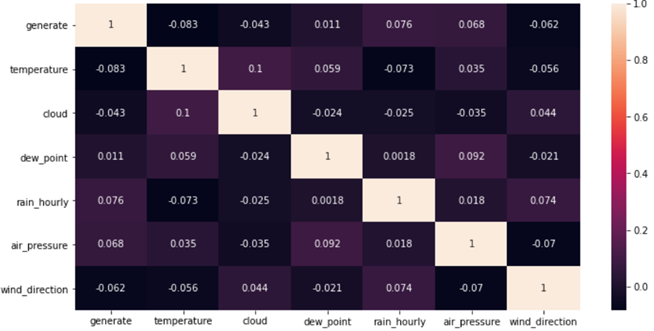


**Step 5-8.**

지역 번호(region_id)별로 생성된 7x7 피어슨 상관계수 테이블 9개로부터 각 [행, 열] 위치마다 

동일한 위치에 있는(동일한 변수의 조합으로 계산된) 9개 값들에 대한 각각의 평균을 계산하여, 

최종적으로 한 개의 7x7 피어슨 상관계수 평균 테이블을 얻는다.

이렇게 얻은 7x7 피어슨 상관계수 평균 테이블로부터, 

날씨 관련 6개 컬럼(temperature, cloud, dew_point, rain_hourly, air_pressure, wind_direction)’ 중 

에너지 생산량(generate)과의 상관계수 절댓값이 가장 큰 feature를 구하고, 

'이 때의 feature 이름'과 '상관계수 절댓값'을 순서대로 기술하시오. 

상관계수 절댓값은 소수점 넷째 자리에서 반올림하여 셋째 자리까지 기술하시오.

(답안예시) cloud, 0.123


## 문제 6번 10점

(master_dataset_1을 이용하여) 이번 문제에서는 에너지 생산량(generate)을 예측하는 

선형 회귀(Linear Regression) 모델 학습 및 평가를 수행한다. 

다음 단계에 따라 지시를 수행한 후 질문에 답하시오.


**Step 6-1.**

에너지 생산량(generate)은 지역과 시간대에 따라 큰 편차를 보인다. 

이를 보완하기 위해, 자연상수 e를 밑으로 하는 log 함수를 적용하여 generate_log 컬럼(아래 정의 참고)을 생성한다.

$generate\_log=log(generate + 1)$

**Step 6-2.**

일시(datetime) 컬럼을 3개의 수치형 컬럼 ‘월(month), 일(day), 시간대(hour)’로 분리하여 저장한다.

**Step 6-3.**

총 14개 컬럼 

'generate_log, area, construct_year, num_floors, temperature, cloud, dew_point, rain_hourly, air_pressure, wind_direction, hour, day, month, usage’를 추출한다. 그 후 ‘construct_year’ 컬럼이 결측치인 행은 제거하고, ‘num_floors, cloud, rain_hourly, air_pressure'

컬럼들에 포함된 결측치는 0으로 대체한다.

Hint. 작업 완료 후 데이터셋은 91,148개의 행을 가진다.

이 작업까지 수행한 데이터셋을 ‘master_dataset_2’로 지정한다. (문제 7에서 사용 예정)

**Step 6-4.**

위 Step 6-3에서 추출한 14개 컬럼들 중 ‘generate_log’를 종속변수로, 

사용용도(usage)를 제외한 나머지 12개 컬럼들을 독립변수로 포함하는 Linear Regression 모델을 생성한다. 

모델 학습에는 모든 데이터를 사용한다.

**Python 함수가이드**
```
from sklearn.linear_model import LinearRegression
- 문제지시 외 파라미터는 default 값 사용
```

위 절차에 따라 생성된 모델을 학습한 데이터에 다시 적용하였을 때의 RMSE(root mean square error)를 계산하고, 

소수점 넷째 자리에서 반올림하여 셋째 자리까지 기술하시오.

$RMSE=\sqrt{\frac{1}{N}\sum_{t=1}^n(\hat{y_i} - y_i)^2}$     ($\hat{y}$  : 예측값, $y$: 실제값)

(답안예시) 1.234

## 문제 7번 10점

**(master_dataset_2를 이용하여)** 이번 문제에서는 OLS(Ordinary Least Squares) 방식을 따르지 않고 

Penalty Term을 적용하는 Ridge Regression 모델링을 수행하며, 

Feature 가공을 통해 모델의 성능을 향상시킨다. 

다음 단계에 따라 지시를 수행한 후 질문에 답하시오.

**Step 7-1.**

범주형(categorical) 변수에 해당하는 사용용도(usage)를 회귀모형의 독립변수로 포함시키기 위해서, 

사용용도(usage)의 수준(level)별 ‘generate_log’의 평균을 집계한 값으로 ‘usage_numeric’ 컬럼을 생성한다.

예시] If (usage=6), then {usage_numeric=(usage가 6인 데이터들의 ‘generate_log’ 평균값)}


**Step 7-2.**

자연상수 e를 밑으로 하는 log 함수를 건물면적(area)과 층 수(num_floors)에 각각 적용하여 

area_log, num_floors_log 컬럼(아래 정의 참고)을 생성한다:

```
area_log⁡=log⁡(area+1)

num_floors_log⁡=log⁡(num_floors+1)
```


**Step 7-3.**

총 14개 컬럼 

'generate_log, area_log, construct_year, num_floors_log, temperature, cloud, dew_point, rain_hourly, air_pressure, wind_direction, hour, day, month, usage_numeric'

을 추출한다.


**Step 7-4.**

위 Step 7-3에서 추출한 컬럼들 중 ‘generate_log’를 종속변수로, 

그 외 13개 컬럼들을 독립변수로 하는 Ridge Linear Regression 모델을 생성한다. 

모델 학습에는 모든 데이터를 사용한다.

**Python 함수가이드**
```
from sklearn.linear_model import Ridge
- alpha = 0.001
- max_iter = 1000
- tol=1e-3
- random_state = 1234
- 문제지시 외 파라미터는 default 값 사용
```

위 절차에 따라 생성된 모델을 학습한 데이터에 다시 적용하였을 때의 RMSE(root mean square error)를 계산하고, 

소수점 넷째 자리에서 반올림하여 셋째 자리까지 기술하시오.

(답안예시) 0.123